# Association Rule Generation from Transaction Data

## Dataset Inspection

### Imports

In [1]:
import pandas as pd

### Load Data

In [2]:
file_path = './Grocery_Items_6/Grocery_Items_6.csv'
data = pd.read_csv(file_path)

### Analysis

In [3]:
transactions = data.apply(lambda row: row.dropna().tolist(), axis=1)
items = transactions.explode()
items_counts = items.value_counts()

num_unique_items = len(items_counts)
num_records = len(data)
most_popular_item = items_counts.idxmax()
most_popular_item_trans_count = data.apply(lambda row: most_popular_item in row.values, axis=1).sum()

### Results

In [4]:
print(f"Number of unique items: {num_unique_items}")
print(f"Number of records: {num_records}")
print(f"The most popular item is '{most_popular_item}' that appeared in {most_popular_item_trans_count} transactions.")

Number of unique items: 167
Number of records: 8000
The most popular item is 'whole milk' that appeared in 1279 transactions.


## Association Rules with Minimum Support and Confidence

### Imports

In [5]:
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules

### Generating Rules

In [6]:
transactions_list = transactions.tolist()

te = TransactionEncoder()
te_array = te.fit(transactions_list).transform(transactions_list)
df = pd.DataFrame(te_array, columns=te.columns_)

frequent_itemsets = apriori(df, min_support=0.01, use_colnames=True)

num_itemsets = len(frequent_itemsets)
rules = association_rules(frequent_itemsets, num_itemsets=num_itemsets, metric='confidence', min_threshold=0.08)

### Results

In [7]:
print("Association Rules:")
print(rules)

Association Rules:
          antecedents         consequents  antecedent support  \
0  (other vegetables)        (rolls/buns)            0.126875   
1        (rolls/buns)  (other vegetables)            0.109000   
2  (other vegetables)              (soda)            0.126875   
3              (soda)  (other vegetables)            0.093625   
4  (other vegetables)        (whole milk)            0.126875   
5        (whole milk)  (other vegetables)            0.159875   
6        (whole milk)        (rolls/buns)            0.159875   
7        (rolls/buns)        (whole milk)            0.109000   
8              (soda)        (whole milk)            0.093625   
9            (yogurt)        (whole milk)            0.086625   

   consequent support   support  confidence      lift  representativity  \
0            0.109000  0.012375    0.097537  0.894834               1.0   
1            0.126875  0.012375    0.113532  0.894834               1.0   
2            0.093625  0.011375    0.089

## Heatmap of Rule Counts

### Imports

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

### Thresholds 

In [9]:
support_values = [0.001, 0.005, 0.01]
confidence_values = [0.05, 0.075, 0.1]

### Rule Counts

In [10]:
rule_counts = []

for msv in support_values:
    row = []
    for mct in confidence_values:
        frequent_itemsets = apriori(df, min_support=msv, use_colnames=True)
        num_itemsets = len(frequent_itemsets)
        rules = association_rules(frequent_itemsets, num_itemsets=num_itemsets, metric='confidence', min_threshold=mct)
        row.append(len(rules))
    rule_counts.append(row)

### Plotting Heatmap

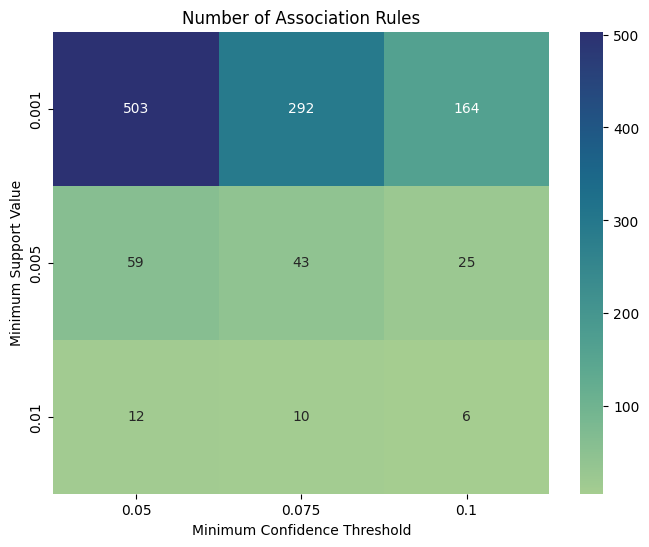

In [11]:
heatmap_data = pd.DataFrame(rule_counts, index=support_values, columns=confidence_values)

plt.figure(figsize=(8, 6))
sns.heatmap(heatmap_data, annot=True, fmt="d", cmap="crest")
plt.title("Number of Association Rules")
plt.xlabel("Minimum Confidence Threshold")
plt.ylabel("Minimum Support Value")
plt.show()

# Image Classification using CNN

## Data Preparations

### Imports

In [12]:
import os
import glob
import numpy as np
from skimage import io, color, transform

import keras
from keras import layers
from sklearn.model_selection import train_test_split

<frozen importlib._bootstrap>:488: DeprecationWarning: Type google._upb._message.MessageMapContainer uses PyType_Spec with a metaclass that has custom tp_new. This is deprecated and will no longer be allowed in Python 3.14.
<frozen importlib._bootstrap>:488: DeprecationWarning: Type google._upb._message.ScalarMapContainer uses PyType_Spec with a metaclass that has custom tp_new. This is deprecated and will no longer be allowed in Python 3.14.
2024-11-30 20:38:48.658157: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Loading Images

In [13]:
def load_images(image_paths, target_size, label_mapping):
    images = []
    labels = []
    for image_path in image_paths:
        class_label = os.path.basename(os.path.dirname(image_path))
        class_label = label_mapping[class_label] 
        image = io.imread(image_path)
        image = color.rgb2gray(image) 
        image = transform.resize(image, target_size, anti_aliasing=True)
        images.append(image)
        labels.append(class_label)
    return np.array(images), np.array(labels)

### Dataset Setup

In [14]:
images_folder = './data/Images/*/*'
image_paths = glob.glob(images_folder)

class_labels = [os.path.basename(os.path.dirname(path)) for path in image_paths]
unique_labels = np.unique(class_labels)
label_mapping = {label: i for i, label in enumerate(unique_labels)}

size = 64
image_size=(size, size)

images, labels = load_images(image_paths, image_size, label_mapping)

### Settings

In [15]:
num_classes = 4
epochs = 40
batch_size = 64
filter_sizes = [3, 5, 7]
input_shape=(size, size, 1)

### Data Preprocessing and Splitting

In [16]:
x_train, x_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, train_size=0.8, random_state=42)

x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255

x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)

print("x_train shape:", x_train.shape)

print(x_train.shape[0], "train samples")
print(x_test.shape[0], "test samples")

y_train = keras.utils.to_categorical(y_train,  num_classes=num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes=num_classes)

x_train shape: (505, 64, 64, 1)
505 train samples
127 test samples


## Build the Model

### Building CNN Model

In [17]:
def build_model(input_shape, num_classes, filter_size_2nd_layer):
    
    model = keras.Sequential(
        [
            #keras.Input(shape=input_shape),
            layers.Conv2D(8, kernel_size=(3, 3), activation="relu"),
            layers.MaxPooling2D(pool_size=(2, 2)),
            layers.Conv2D(4, kernel_size=(filter_size_2nd_layer, filter_size_2nd_layer), activation="relu"),
            layers.MaxPooling2D(pool_size=(2, 2)),
            layers.Flatten(),
            layers.Dense(8, activation="relu"),
            layers.Dense(num_classes, activation="softmax"),
        ]
    )

    return model

### ImageDataGenerator

In [18]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

x_train_split, x_val_split, y_train_split, y_val_split = train_test_split(x_train, y_train, test_size=0.2)

train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow(x_train_split, y_train_split, batch_size=batch_size)
val_generator = val_datagen.flow(x_val_split, y_val_split, batch_size=batch_size)

### Training the Model

In [19]:
def train_model(x_train, y_train, input_shape, num_classes, epochs, batch_size, filter_size_2nd_layer):
    
    model = build_model(input_shape, num_classes, filter_size_2nd_layer)
    
    model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
    
    history = model.fit(
        train_generator,
        #x_train, 
        #y_train, 
        #batch_size=batch_size, 
        epochs=epochs, 
        #validation_split=0.2
        validation_data=val_generator
    )
    
    return model, history

### Ploting Learning Curves

In [20]:
def plot_learning_curves(history, title):
    plt.figure(figsize=(10, 8))
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel("Epochs", fontsize=16)
    plt.ylabel("Accuracy", fontsize=16)
    plt.title(title, fontsize=20)
    plt.legend(fontsize=14)
    plt.grid()
    plt.show()

###  3x3 filter for the second layer Model

In [21]:
model_3x3, history_3x3 = train_model(
    x_train, 
    y_train,
    input_shape=input_shape, 
    num_classes=num_classes, 
    epochs=epochs, 
    batch_size=batch_size, 
    filter_size_2nd_layer=filter_sizes[0]
)

Epoch 1/40


/Users/lisa/Library/jupyterlab-desktop/jlab_server/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 80ms/step - accuracy: 0.2587 - loss: 1.3862 - val_accuracy: 0.1386 - val_loss: 1.3885
Epoch 2/40
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.2930 - loss: 1.3860 - val_accuracy: 0.2772 - val_loss: 1.3885
Epoch 3/40
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.2581 - loss: 1.3853 - val_accuracy: 0.1386 - val_loss: 1.3899
Epoch 4/40
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.2682 - loss: 1.3853 - val_accuracy: 0.2772 - val_loss: 1.3905
Epoch 5/40
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.3228 - loss: 1.3834 - val_accuracy: 0.2772 - val_loss: 1.3933
Epoch 6/40
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.2858 - loss: 1.3841 - val_accuracy: 0.1386 - val_loss: 1.3951
Epoch 7/40
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.2561 - loss: 1.3831 - val_accuracy: 0.2772 - val_loss: 1.3963
Epoch 8/40
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.2685 - loss: 1.3824 - val_accuracy: 0.2772 - val_loss: 1.3990
Epoch 9/40


### 3x3 Model Summary and Plot

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 62, 62, 8)      │            80 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 31, 31, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 29, 29, 4)      │           292 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 14, 14, 4)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 8)              │         6,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │            36 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,066 (78.39 KB)

 Trainable params: 6,688 (26.12 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 13,378 (52.26 KB)


Test loss: 1.395674228668213
Test accuracy: 0.19685038924217224


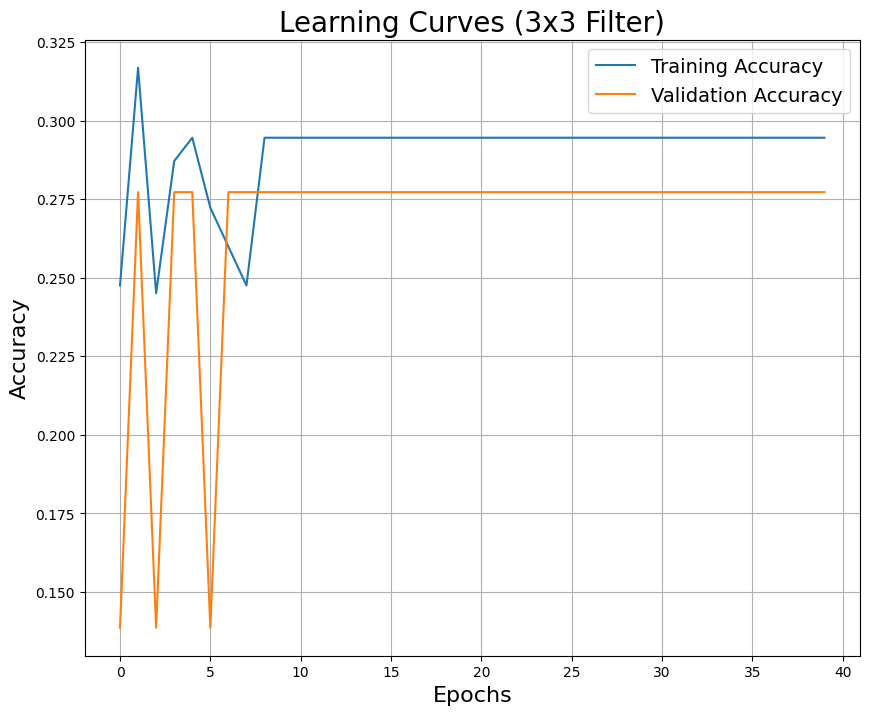

In [22]:
model_3x3.summary()

score_3x3 = model_3x3.evaluate(x_test, y_test, verbose=0)
print("\nTest loss:", score_3x3[0])
print("Test accuracy:", score_3x3[1])

plot_learning_curves(history_3x3, "Learning Curves (3x3 Filter)")

## Experiment (a) - BannerID[916368000]

###  5x5 filter for the second layer Model

In [23]:
model_5x5, history_5x5 = train_model(
    x_train, 
    y_train, 
    input_shape=input_shape, 
    num_classes=num_classes, 
    epochs=epochs, 
    batch_size=batch_size, 
    filter_size_2nd_layer=filter_sizes[1]
)

Epoch 1/40
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 86ms/step - accuracy: 0.1973 - loss: 1.3863 - val_accuracy: 0.2772 - val_loss: 1.3853
Epoch 2/40
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.2889 - loss: 1.3860 - val_accuracy: 0.2772 - val_loss: 1.3854
Epoch 3/40
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.2789 - loss: 1.3859 - val_accuracy: 0.2772 - val_loss: 1.3866
Epoch 4/40
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.2918 - loss: 1.3854 - val_accuracy: 0.2772 - val_loss: 1.3870
Epoch 5/40
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.3044 - loss: 1.3855 - val_accuracy: 0.2772 - val_loss: 1.3867
Epoch 6/40
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.3117 - loss: 1.3848 - val_accuracy: 0.2772 - val_loss: 1.3865
Epoch 7/40
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.2976 - loss: 1.3844 - val_accuracy: 0.2772 - val_loss: 1.3868
Epoch 8/40
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.2920 - loss: 1.3849 - val_accuracy: 0.2772 - val_loss: 1.3871


### 5x5 Model Summary and Plot

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 62, 62, 8)      │            80 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 31, 31, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 27, 27, 4)      │           804 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 13, 13, 4)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 676)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 8)              │         5,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │            36 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,010 (74.26 KB)

 Trainable params: 6,336 (24.75 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 12,674 (49.51 KB)


Test loss: 1.4009714126586914
Test accuracy: 0.19685038924217224


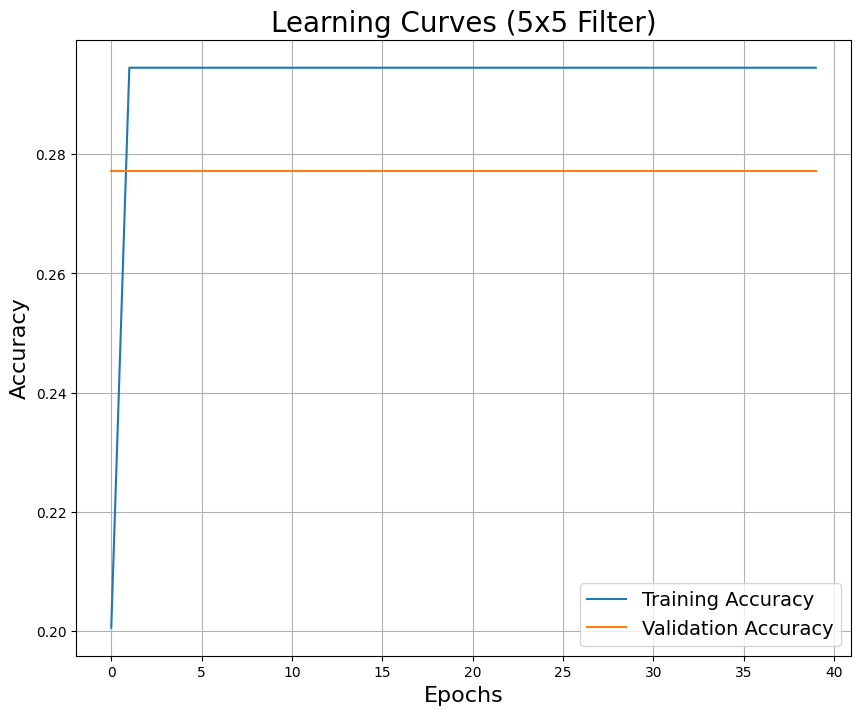

In [24]:
model_5x5.summary()

score_5x5 = model_5x5.evaluate(x_test, y_test, verbose=0)
print("\nTest loss:", score_5x5[0])
print("Test accuracy:", score_5x5[1])

plot_learning_curves(history_5x5, "Learning Curves (5x5 Filter)")

###  7x7 filter for the second layer Model

In [25]:
model_7x7, history_7x7 = train_model(
    x_train, 
    y_train,
    input_shape=input_shape, 
    num_classes=num_classes, 
    epochs=epochs, 
    batch_size=batch_size, 
    filter_size_2nd_layer=filter_sizes[2]
)

Epoch 1/40
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 106ms/step - accuracy: 0.2995 - loss: 1.3862 - val_accuracy: 0.2772 - val_loss: 1.3861
Epoch 2/40
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.3076 - loss: 1.3854 - val_accuracy: 0.2772 - val_loss: 1.3867
Epoch 3/40
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.3120 - loss: 1.3842 - val_accuracy: 0.2772 - val_loss: 1.3878
Epoch 4/40
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.2845 - loss: 1.3846 - val_accuracy: 0.2772 - val_loss: 1.3894
Epoch 5/40
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.2913 - loss: 1.3830 - val_accuracy: 0.2772 - val_loss: 1.3926
Epoch 6/40
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.3177 - loss: 1.3801 - val_accuracy: 0.2772 - val_loss: 1.3961
Epoch 7/40
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.2885 - loss: 1.3859 - val_accuracy: 0.2772 - val_loss: 1.3945
Epoch 8/40
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.2659 - loss: 1.3855 - val_accuracy: 0.2772 - val_loss: 1.3946

### 7x7 Model Summary and Plot

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 62, 62, 8)      │            80 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 31, 31, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 25, 25, 4)      │         1,572 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 12, 12, 4)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 576)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 8)              │         4,616 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 4)              │            36 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,914 (73.89 KB)

 Trainable params: 6,304 (24.62 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 12,610 (49.26 KB)


Test loss: 1.3989439010620117
Test accuracy: 0.19685038924217224


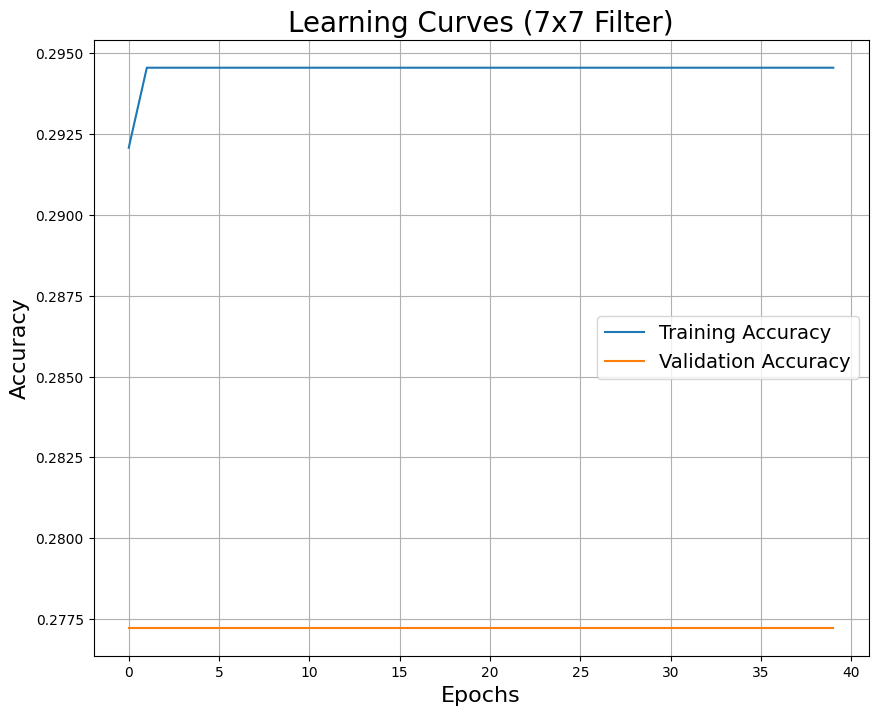

In [26]:
model_7x7.summary()

score_7x7 = model_7x7.evaluate(x_test, y_test, verbose=0)
print("\nTest loss:", score_7x7[0])
print("Test accuracy:", score_7x7[1])

plot_learning_curves(history_7x7, "Learning Curves (7x7 Filter)")

## Conclution

### Ploting Learning Curves for All Models

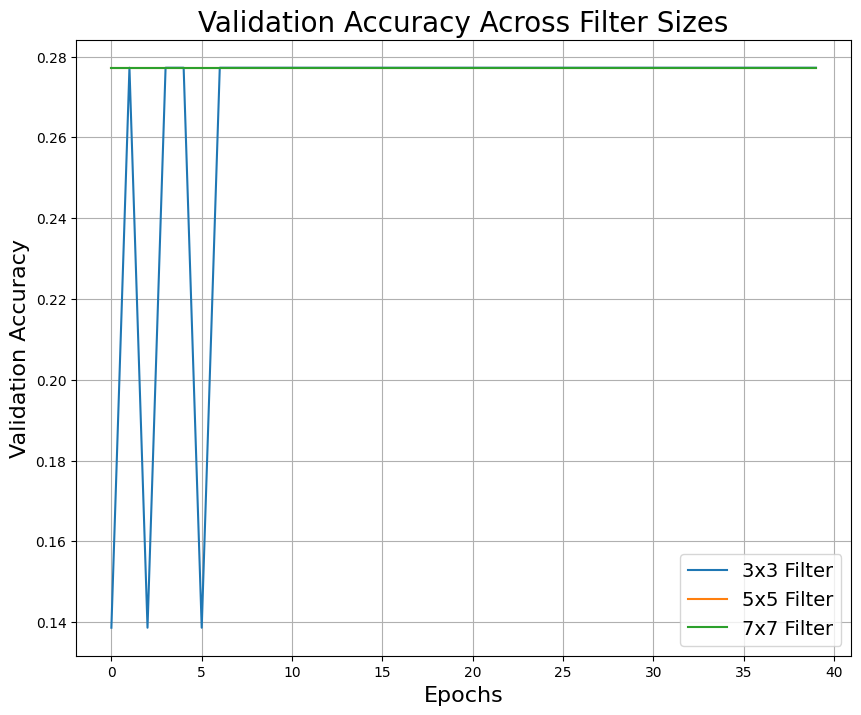

In [27]:
plt.figure(figsize=(10, 8))
plt.plot(history_3x3.history['val_accuracy'], label='3x3 Filter')
plt.plot(history_5x5.history['val_accuracy'], label='5x5 Filter')
plt.plot(history_7x7.history['val_accuracy'], label='7x7 Filter')
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Validation Accuracy', fontsize=16)
plt.title('Validation Accuracy Across Filter Sizes', fontsize=20)
plt.legend(fontsize=14)
plt.grid()
plt.show()

### Model Performance Analyzis

In [28]:
print(f"3x3 Filter - Final Training Accuracy: {history_3x3.history['accuracy'][-1]:.2f}, Validation Accuracy: {history_3x3.history['val_accuracy'][-1]:.2f}")
print(f"5x5 Filter - Final Training Accuracy: {history_5x5.history['accuracy'][-1]:.2f}, Validation Accuracy: {history_5x5.history['val_accuracy'][-1]:.2f}")
print(f"7x7 Filter - Final Training Accuracy: {history_7x7.history['accuracy'][-1]:.2f}, Validation Accuracy: {history_7x7.history['val_accuracy'][-1]:.2f}")

def analyze_model_performance(history):
    train_acc = history.history['accuracy'][-1]
    val_acc = history.history['val_accuracy'][-1]

    if train_acc > val_acc + 0.05: 
        return "Overfitting"
    elif train_acc < 0.6 and val_acc < 0.6: 
        return "Underfitting"
    else:
        return "Just right"

print(f"3x3 Filter Performance: {analyze_model_performance(history_3x3)}")
print(f"5x5 Filter Performance: {analyze_model_performance(history_5x5)}")
print(f"7x7 Filter Performance: {analyze_model_performance(history_7x7)}")

3x3 Filter - Final Training Accuracy: 0.29, Validation Accuracy: 0.28
5x5 Filter - Final Training Accuracy: 0.29, Validation Accuracy: 0.28
7x7 Filter - Final Training Accuracy: 0.29, Validation Accuracy: 0.28
3x3 Filter Performance: Underfitting
5x5 Filter Performance: Underfitting
7x7 Filter Performance: Underfitting


### Observations

- Increasing the filter size does not appear to impact either the validation accuracy or the training accuracy significantly.
- Occasionally, some reruns showed a slight improvement in one of the models, but overall, all three models consistently exhibited underfitting.
  
- I explored various strategies to address the underfitting issue. These included applying class weights, implementing early stopping, adjusting the batch size, and utilizing the ImageDataGenerator for augmentation. Unfortunately, none of these approaches resulted in a significant improvement.
- The only aspect I did not experiment with was modifying the model architecture, as doing so would conflict with the assignment requirements.

# Text Classification by fine-tuning LLM model

## Loading Dataset

### Imports

In [29]:
from datasets import load_dataset

### Loading Data

In [30]:
train_dataset = load_dataset('json', data_files={'train': './student_6/train.json'}, split='train')
test_dataset = load_dataset('json', data_files={'test': './student_6/test.json'}, split='test')
val_dataset = load_dataset('json', data_files={'validation': './student_6/validation.json'}, split='validation')

### Creating a List of Labels

In [31]:
labels = [label for label in train_dataset.features.keys() if label not in ['ID', 'Tweet']]
id2label = {idx:label for idx, label in enumerate(labels)}
label2id = {label:idx for idx, label in enumerate(labels)}
labels

['anger',
 'anticipation',
 'disgust',
 'fear',
 'joy',
 'love',
 'optimism',
 'pessimism',
 'sadness',
 'surprise',
 'trust']

## Preprocess data

### Imports

In [32]:
from transformers import AutoTokenizer

### Initializing BERT tokenizer

In [33]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

### Preparing Data 

In [34]:
def preprocess_data(examples):
  # take a batch of texts
  text = examples["Tweet"]
  # encode them
  encoding = tokenizer(text, padding="max_length", truncation=True, max_length=128)
  # add labels
  labels_batch = {k: examples[k] for k in examples.keys() if k in labels}
  # create numpy array of shape (batch_size, num_labels)
  labels_matrix = np.zeros((len(text), len(labels)))
  # fill numpy array
  for idx, label in enumerate(labels):
    labels_matrix[:, idx] = labels_batch[label]

  encoding["labels"] = labels_matrix.tolist()
  
  return encoding

### Encoding Datasets

In [35]:
encoded_train_dataset = train_dataset.map(preprocess_data, 
                              batched=True, 
                              remove_columns=train_dataset.column_names)

encoded_test_dataset = test_dataset.map(preprocess_data, 
                              batched=True, 
                              remove_columns=test_dataset.column_names)

encoded_val_dataset = val_dataset.map(preprocess_data, 
                              batched=True, 
                              remove_columns=val_dataset.column_names)

/Users/lisa/Library/jupyterlab-desktop/jlab_server/lib/python3.12/site-packages/datasets/utils/_dill.py:379: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
  obj.co_lnotab,  # for < python 3.10 [not counted in args]
/Users/lisa/Library/jupyterlab-desktop/jlab_server/lib/python3.12/site-packages/datasets/utils/_dill.py:379: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
  obj.co_lnotab,  # for < python 3.10 [not counted in args]
/Users/lisa/Library/jupyterlab-desktop/jlab_server/lib/python3.12/site-packages/datasets/utils/_dill.py:379: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
  obj.co_lnotab,  # for < python 3.10 [not counted in args]


In [36]:
example = encoded_train_dataset[0]
print(example.keys())

dict_keys(['input_ids', 'token_type_ids', 'attention_mask', 'labels'])


In [37]:
tokenizer.decode(example['input_ids'])

'[CLS] watch this amazing live. ly broadcast by @ broitzmax # musically [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]'

In [38]:
example['labels']

[0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0]

In [39]:
[id2label[idx] for idx, label in enumerate(example['labels']) if label == 1.0]

['anticipation', 'joy', 'optimism', 'surprise', 'trust']

In [40]:
encoded_train_dataset.set_format("torch")
encoded_test_dataset.set_format("torch")
encoded_val_dataset.set_format("torch")

## Defining Model

### Imports

In [41]:
from transformers import AutoModelForSequenceClassification

### Model Setup

In [42]:
model = AutoModelForSequenceClassification.from_pretrained("bert-base-uncased", 
                                                           problem_type="multi_label_classification", 
                                                           num_labels=len(labels),
                                                           id2label=id2label,
                                                           label2id=label2id)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Train the Model

### Imports

In [43]:
from transformers import TrainingArguments, Trainer

from sklearn.metrics import f1_score, roc_auc_score, accuracy_score
from transformers import EvalPrediction
import torch

### Training Setup

In [44]:
batch_size = 8
metric_name = "f1"

args = TrainingArguments(
    f"bert-finetuned-sem_eval-english",
    eval_strategy = "epoch",
    save_strategy = "epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=5,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model=metric_name,
    logging_steps=375  
)

### Compute Metrics

In [45]:
def multi_label_metrics(predictions, labels, threshold=0.5):
    # first, apply sigmoid on predictions which are of shape (batch_size, num_labels)
    sigmoid = torch.nn.Sigmoid()
    probs = sigmoid(torch.Tensor(predictions))
    # next, use threshold to turn them into integer predictions
    y_pred = np.zeros(probs.shape)
    y_pred[np.where(probs >= threshold)] = 1
    # finally, compute metrics
    y_true = labels
    f1_micro_average = f1_score(y_true=y_true, y_pred=y_pred, average='micro')
    roc_auc = roc_auc_score(y_true, y_pred, average = 'micro')
    accuracy = accuracy_score(y_true, y_pred)
    # return as dictionary
    metrics = {'f1': f1_micro_average,
               'roc_auc': roc_auc,
               'accuracy': accuracy}
    return metrics

def compute_metrics(p: EvalPrediction):
    preds = p.predictions[0] if isinstance(p.predictions, 
            tuple) else p.predictions
    result = multi_label_metrics(
        predictions=preds, 
        labels=p.label_ids)
    return result

### Batch and Forward Pass Verification

In [46]:
encoded_train_dataset[0]['labels'].type()

'torch.FloatTensor'

In [47]:
encoded_train_dataset['input_ids'][0]

tensor([  101,  3422,  2023,  6429,  2444,  1012,  1048,  2100,  3743,  2011,
         1030, 22953,  8838, 17848,  1001, 21385,   102,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0])

In [48]:
#forward pass
outputs = model(input_ids=encoded_train_dataset['input_ids'][0].unsqueeze(0), labels=encoded_train_dataset['labels'][0].unsqueeze(0))
outputs

We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.


SequenceClassifierOutput(loss=tensor(0.7137, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), logits=tensor([[-0.1306, -0.0670, -0.0216,  0.0441, -0.3206,  0.1834,  0.1068,  0.1501,
         -0.3471,  0.0302, -0.2305]], grad_fn=<AddmmBackward0>), hidden_states=None, attentions=None)

### Training

In [49]:
trainer = Trainer(
    model,
    args,
    train_dataset=encoded_train_dataset,
    eval_dataset=encoded_val_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

In [50]:
trainer.train()

Epoch,Training Loss,Validation Loss,F1,Roc Auc,Accuracy
1,0.426800,0.361828,0.587855,0.716606,0.202500
2,0.319800,0.325166,0.661088,0.763186,0.250000
3,0.269900,0.322876,0.677551,0.775578,0.260000
4,0.238900,0.320428,0.692699,0.788496,0.275000
5,0.218900,0.320308,0.697858,0.792104,0.292500


TrainOutput(global_step=1875, training_loss=0.29485724283854164, metrics={'train_runtime': 6628.2968, 'train_samples_per_second': 2.263, 'train_steps_per_second': 0.283, 'total_flos': 986746187520000.0, 'train_loss': 0.29485724283854164, 'epoch': 5.0})

### Evaluation

In [51]:
trainer.evaluate()

{'eval_loss': 0.32030755281448364,
 'eval_f1': 0.6978579481397971,
 'eval_roc_auc': 0.792104234919299,
 'eval_accuracy': 0.2925,
 'eval_runtime': 141.4497,
 'eval_samples_per_second': 2.828,
 'eval_steps_per_second': 0.353,
 'epoch': 5.0}

## Extracting Losses and Plotting Curves

### Extract Training and Validation Losses

In [57]:
train_losses = [log["loss"] for log in trainer.state.log_history if "loss" in log]
val_losses = [log["eval_loss"] for log in trainer.state.log_history if "eval_loss" in log]

### Ploting Learning Curves

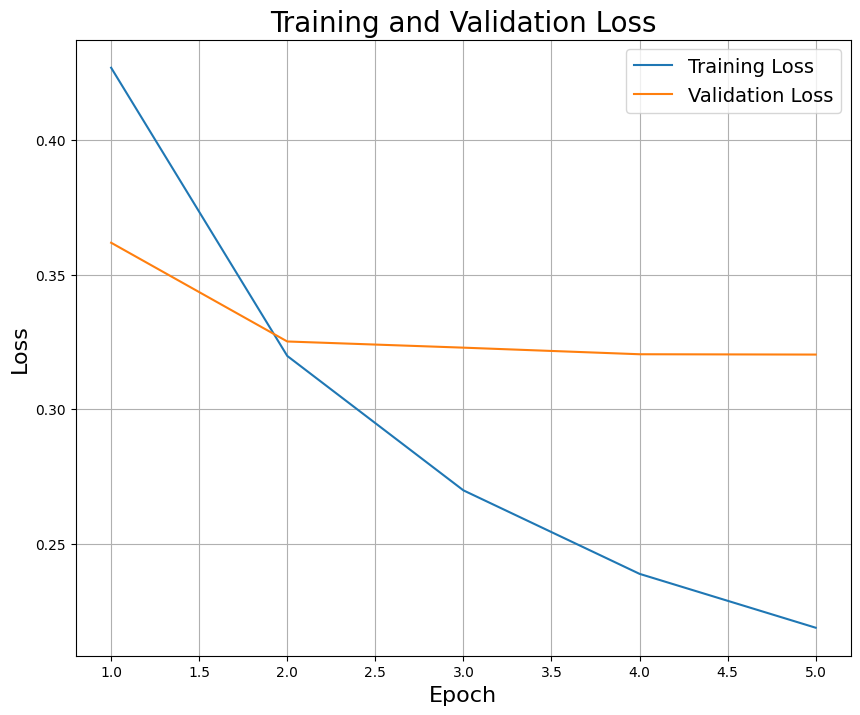

In [58]:
val_losses = val_losses[:len(epochs)]
epochs = range(1, len(train_losses) + 1)

plt.figure(figsize=(10, 8))
plt.plot(epochs, train_losses, label="Training Loss")
plt.plot(epochs, val_losses, label="Validation Loss")
plt.xlabel("Epoch", fontsize=16)
plt.ylabel("Loss", fontsize=16)
plt.legend(fontsize=14)
plt.title("Training and Validation Loss", fontsize=20)
plt.grid()
plt.show()

## Accuracy Calculation

### Predicting

In [74]:
all_predictions = []
all_true_labels = []

for example in test_dataset:

    encoding = tokenizer(example['Tweet'], return_tensors="pt", padding="max_length", truncation=True, max_length=128)
    encoding = {k: v.to(trainer.model.device) for k, v in encoding.items()}  

    outputs = trainer.model(**encoding)
    logits = outputs.logits  

    sigmoid = torch.nn.Sigmoid()
    probs = sigmoid(logits.squeeze().cpu())
    predictions = (probs >= 0.5).int().tolist()  
    all_predictions.append(predictions)

    true_labels = [int(example[label]) for label in labels]  
    all_true_labels.append(true_labels)

### Computing Exact and Partial Match Accuracy

In [75]:
true_labels_tensor = torch.tensor(all_true_labels)
predicted_labels_tensor = torch.tensor(all_predictions)

def compute_exact_match(predictions, labels):
    return (predictions == labels).all(dim=1).float().mean().item()

def compute_partial_match(predictions, labels):
    return ((predictions & labels).sum(dim=1) > 0).float().mean().item()

exact_match_accuracy = compute_exact_match(predicted_labels_tensor, true_labels_tensor)
partial_match_accuracy = compute_partial_match(predicted_labels_tensor, true_labels_tensor)

print(f"Exact Match Accuracy: {exact_match_accuracy:.4f}")
print(f"Partial Match Accuracy: {partial_match_accuracy:.4f}")

Exact Match Accuracy: 0.2680
Partial Match Accuracy: 0.8593
